In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## Import the necessary libraries
## This list will get modified as needed

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import *
import seaborn as sns
from sklearn.model_selection import *
from sklearn.metrics import *
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
## Confirm the versions of Keras and Tensorflow - to confirm we have the most up to date
## We should see 2.3 and 2.0 and .24.2

print(keras.__version__)
print()
print(tf.__version__)
print()
print(pd.__version__)

2.3.0

2.0.0

0.24.2


In [6]:
## Remove annoying DeprecationWarnings from sklearn - I will upgrade after this project!

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import warnings
warnings.filterwarnings("ignore")

# <span style="color:#ffcc33">Project Background</span>

<span style="color:#7a0019"><b>MSBA 6420 - Predictive Analytics - Group 1</b><br><br>
Analysts:
- Danny Moncada (monca016@umn.edu)
- Eduardo Chavez (echavezh@umn.edu)

# Google Analytics Customer Revenue Prediction [1]

From competition notes:

<span style="color:blue">"The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

<span style="color:blue">RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

<span style="color:blue">In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data."

In our predictive modeling analysis, we will perform the following steps:
<br>
<br>
A. <b>Data Preprocessing and Loading</b><br>
B. <b>Feature Selection & Exploratory Analysis</b><br>
C. <b>Model Development, Assessment, and Testing</b><br>
D. <b>"Best" Model Identification & Parameter Tuning</b><br>
E. <b>Final Model Training, Predictions, and Submission Output</b>

<i>Appendix: Model performance evaluation (separate notebook)</i>

# <span style="color:#ffcc33">A. Data loading and pre-processing</span>

- At first we attempted to use BigQuery in Google Analytics to flatten the training and testing data sets into flattened files for easier consumption but had significant challenges loading the data.
- Very luckily for us, someone had developed a custom function to read through all of the JSON columns and convert them into individual columns, which you will see below (credit to user will be at the end of the notebook). [2]
- We then load the files that we flattened into our shared drive and start from here.

In [7]:
## Create a custom function to transform JSON formatted columns
## This will flatten the CSVs into a format that it is easier to understand
## And will unpack all of the JSON nested columns

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path = 'D:\\Group Project - Google\\datasets\\test_v2.csv', nrows=None):
    
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters = {column: json.loads for column in JSON_COLUMNS}, 
                     dtype = {'fullVisitorId': 'str'}, ## Transform fullVisitorId to string field for de-duping and grouping later
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    
    return df

In [8]:
## List the different files we have available in the Group Project folder
## The main files that we need for this analysis are:

## train-flattened.csv - flattened version for training data
## test_2-flattened.csv - flattened version for testing data

print(os.listdir("D:\\Group Project - Google\\datasets"))

['custom.css', 'sample_submission_v2.csv', 'test-flattened.csv', 'test_2-flattened.csv', 'test_v2.csv', 'test_v2.csv.zip', 'train-flattened.csv', 'train_v2.csv.zip', '__results__.html']


In [8]:
## Set the working directory

## Working directory - for MSBA 6420 Virtual Machine
working_dir = "D:\\Group 1\\datasets\\"

## Working directory - for MSBA 6410 Virtual Machine
##working_dir = "D:\\Group Project - Google\\datasets\\"

## Training Data File - with flattened JSON fields
training_file = "train-flattened.csv"

## Full path to train data file
training_path = working_dir+training_file

## Testing Data File - first version
## testing_file = "test-flattened.csv"

## Full path to test data file
## testing_path = working_dir+testing_file

## Submission Data File - with subset of VisitorIds
submission_file = "sample_submission_v2.csv"

## Full path to submission file
submission_path = working_dir+submission_file

## New testing data file
testing_file_v2 = "test_2-flattened.csv"

testing_v2_path = working_dir+testing_file_v2

In [9]:
## Verify the training and testing paths

print(training_path)

print()

print(testing_v2_path)

D:\Group 1\datasets\train-flattened.csv

D:\Group 1\datasets\test_2-flattened.csv


In [10]:
## Load in the training data from the flattened CSV file

training_data = pd.read_csv(training_path, low_memory = False)

In [11]:
## See the shape of the training data - to know how many dimension/features we have available

training_data.shape

(903653, 55)

## In the original training data file, the row count was 1.7 million - this has been drastically reduced with the flattened file.

## Now the flattened file contains 903653 rows.

In [15]:
## See the first five rows - just to get a sense of the data.

training_data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [76]:
## Look at the column names - we have 55 features to choose from!

training_data.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

## Quite a significant amount of columns / features.  What are we really trying to assess?

"What am I predicting?

We are predicting the <b>natural log</b> of the sum of all transactions <b>per user</b>. Once the data is updated, as noted above, this will be for <b>all users in test_v2.csv for December 1st, 2018 to January 31st, 2019</b>. For every user in the test set, the target is:"

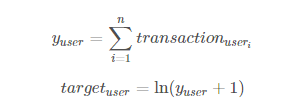

"<b>Note that the dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.</b>" [1]

Based on the competition notes:

- This is both a regression and classifcation problem; to perform the regression, we need a numeric field to use for predictions.  In this analysis, we can use the one labeled "totals.transactionRevenue".
- However, this doesn't provide us a target column for the classification problem, which is simply whether the customer spent money on the site or not.  We can simply create a new column labeled "Purchase", and assign a binary label (1, 0) to it, using the information from the "totals.transactionRevenue" column.  Let's see how this goes!

In [16]:
## Look at a few values for the transactionRevenue field

training_data["totals.transactionRevenue"].unique()

array([       nan, 3.7860e+07, 3.0667e+08, ..., 3.3526e+08, 3.0750e+07,
       6.9390e+07])

In [17]:
## Do a few things here - we'll see what values are NaN
## Then we can see what the spending column looks like

transaction_revenue_not_empty = training_data["totals.transactionRevenue"][training_data["totals.transactionRevenue"].notna()]

## Show the first five rows for Transaction Revenue 
transaction_revenue_not_empty.head()

752     37860000.0
753    306670000.0
799     68030000.0
802     26250000.0
859    574150000.0
Name: totals.transactionRevenue, dtype: float64

In [18]:
## How many rows actually contain revenue information?  In other words, how many rows in our training data have evidence of a purchase?

print("There are {} rows in the data set that actually contain purchase information.".format(len(transaction_revenue_not_empty)))

There are 11515 rows in the data set that actually contain purchase information.


## These values make much more sense than what was originally provided in the data set, at least from a business perspective.  If you want to accurately predict revenue, the output should be in a format that is understandable for the audience.

## As analysts, it helps us understand what problem we am trying to solve by viewing the data in a format that makes more sense.
## As a result, we can create two columns - a "new" revenue column with a denomation that makes more sense based on the simple math above.
## And then a spending column with the binary (1, 0) target.

In [19]:
## Create a new column labeled "Revenue" performing the calculation we identified above

training_data["Revenue"] = training_data["totals.transactionRevenue"] / 1000000

In [20]:
## Confirm our transformation completed successfully

training_data["Revenue"][training_data["Revenue"].notna()].head()

752     37.86
753    306.67
799     68.03
802     26.25
859    574.15
Name: Revenue, dtype: float64

In [21]:
## Next step - create a column labeled "Purchase" - for our classification analysis

## Where the "Revenue" column is not empty, assign the value 1 (for a purchase), otherwise give it a big fat 0
training_data["Purchase"] = np.where(training_data["Revenue"].notna(), 1, 0)

In [22]:
## Confirm that our new column was created successfully - we should see the same counts for 1 that we do for the row counts we did above

print(training_data.Purchase.value_counts())

print()

print(len(transaction_revenue_not_empty))

0    892138
1     11515
Name: Purchase, dtype: int64

11515


## The row counts match!  So now we have our two different target columns, "Purchase" & "Revenue".
## We can move to the next step of splitting the data and transforming it, prior to performing a PCA on it.

In [23]:
## To make our analysis more efficient, and so we don't leave NaN in the Revenue column, we can replace them with 0.  This will help with averages, etc.
## Inplace = True is not usually recommended because you are overwriting data  but we can always re-initialize the data frame if we have to.

training_data["Revenue"].fillna(0, inplace = True)

In [24]:
## Run very basic summary statistics on the training data, we can just very quickly see there are any strange outliers

training_data.describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adwordsClickInfo.page,Revenue,Purchase
count,9.036530e+05,9.036530e+05,903653.000000,9.036530e+05,450630.0,903653.000000,703060.0,903553.000000,1.151500e+04,903653.0,21460.000000,903653.000000,903653.000000
mean,2.016589e+07,1.485007e+09,2.264897,1.485007e+09,1.0,4.596538,1.0,3.849764,1.337448e+08,1.0,1.008108,1.704273,0.012743
std,4.697698e+03,9.022124e+06,9.283735,9.022124e+06,0.0,9.641437,0.0,7.025274,4.482852e+08,0.0,0.173584,52.778659,0.112162
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,1.0,1.000000,1.0,1.000000,1.000000e+04,1.0,1.000000,0.000000,0.000000
25%,2.016103e+07,1.477561e+09,1.000000,1.477561e+09,1.0,1.000000,1.0,1.000000,2.493000e+07,1.0,1.000000,0.000000,0.000000
50%,2.017011e+07,1.483949e+09,1.000000,1.483949e+09,1.0,2.000000,1.0,1.000000,4.945000e+07,1.0,1.000000,0.000000,0.000000
75%,2.017042e+07,1.492759e+09,1.000000,1.492759e+09,1.0,4.000000,1.0,4.000000,1.076550e+08,1.0,1.000000,0.000000,0.000000
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.0,500.000000,1.0,469.000000,2.312950e+10,1.0,14.000000,23129.500000,1.000000


## Prior to running through our PCA, we identified some fields that seemed redudant or did not contain very helpful information.

## We remove those fields here by subsetting the dataframe and only keeping those columns that should help the machine learning algorithms.

In [25]:
## We subset the data to remove a lot of detail that seems unnecessary
training_data_clean = training_data[['channelGrouping','date','socialEngagementType','visitNumber',
                            'geoNetwork.city', 'geoNetwork.country','totals.hits','totals.pageviews', 'totals.visits',
                            'trafficSource.adwordsClickInfo.adNetworkType','trafficSource.source','totals.transactionRevenue',
                                    "Revenue", "Purchase"]]

## Fill the pageviews columns with 0s instead of null values
training_data_clean["totals.pageviews"].fillna(0, inplace = True)

## Then we transform page views into an integer field
training_data_clean["totals.pageviews"] = training_data_clean["totals.pageviews"].astype(int)

## Run some summary statistics on the table - now that we have sliced it down by quite a bit
training_data_clean.describe()

,date,visitNumber,totals.hits,totals.pageviews,totals.visits,totals.transactionRevenue,Revenue,Purchase
count,9.036530e+05,903653.000000,903653.000000,903653.000000,903653.0,1.151500e+04,903653.000000,903653.000000
mean,2.016589e+07,2.264897,4.596538,3.849338,1.0,1.337448e+08,1.704273,0.012743
std,4.697698e+03,9.283735,9.641437,7.025002,0.0,4.482852e+08,52.778659,0.112162
min,2.016080e+07,1.000000,1.000000,0.000000,1.0,1.000000e+04,0.000000,0.000000
25%,2.016103e+07,1.000000,1.000000,1.000000,1.0,2.493000e+07,0.000000,0.000000
50%,2.017011e+07,1.000000,2.000000,1.000000,1.0,4.945000e+07,0.000000,0.000000
75%,2.017042e+07,1.000000,4.000000,4.000000,1.0,1.076550e+08,0.000000,0.000000
max,2.017080e+07,395.000000,500.000000,469.000000,1.0,2.312950e+10,23129.500000,1.000000


In [26]:
## Remove any columns that will not be used as features

feature_cols = training_data_clean.columns[~training_data_clean.columns.isin(["totals.transactionRevenue", "Revenue", "Purchase"])]

## Confirm how many columns we're using for our feature analysis - from 55 to 11!
print(len(feature_cols))
print()
print(feature_cols)

11

Index(['channelGrouping', 'date', 'socialEngagementType', 'visitNumber',
       'geoNetwork.city', 'geoNetwork.country', 'totals.hits',
       'totals.pageviews', 'totals.visits',
       'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.source'],
      dtype='object')


In [27]:
## Build a list of categorical columns of our "clean" training data set - using a filter on columns with string values
categorical_columns = list(training_data_clean.columns[training_data_clean.dtypes == object])

## Fill the columns with string values with a "N/A" instead of an NaN - so that our encoders will work properly!
training_data_clean[categorical_columns] = training_data_clean[categorical_columns].fillna("NA")

## Show the first five rows of the transformed data frame to confirm our transformation was successful
training_data_clean.head()

,channelGrouping,date,socialEngagementType,visitNumber,geoNetwork.city,geoNetwork.country,totals.hits,totals.pageviews,totals.visits,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.source,totals.transactionRevenue,Revenue,Purchase
0,Organic Search,20160902,Not Socially Engaged,1,Izmir,Turkey,1,1,1,NA,google,NaN,0.0,0
1,Organic Search,20160902,Not Socially Engaged,1,not available in demo dataset,Australia,1,1,1,NA,google,NaN,0.0,0
2,Organic Search,20160902,Not Socially Engaged,1,Madrid,Spain,1,1,1,NA,google,NaN,0.0,0
3,Organic Search,20160902,Not Socially Engaged,1,not available in demo dataset,Indonesia,1,1,1,NA,google,NaN,0.0,0
4,Organic Search,20160902,Not Socially Engaged,2,not available in demo dataset,United Kingdom,1,1,1,NA,google,NaN,0.0,0


In [28]:
## Create our "X" variable that contains all the features we would like to use for our model(s)
X = np.array(training_data_clean[feature_cols])

## Create our second "y" variable - for our regression problem
y_regression = np.array(training_data_clean["Revenue"])

# <span style="color:#ffcc33">B.  Feature Selection & Exploratory Analysis</span>

## Now we're ready to start doing some more feature extraction, even though we have whittled our list down to 11 features columns.

## Even after our initial clean-up work, we're still susceptible to the `curse of dimensionality`*.

#### Curse of dimensionality: 

1.  More dimensions leads <i>sparser</i> data
2.  "Noise" from irrelevant dimensions affect the “signal” from relevant dimensions
3.  Distance metrics become increasingly less useful with more dimenions (which is important to us when trying to use KNN)
4.  Probability distributions behave non-intuitively in high-dimensional spaces

In [29]:
## Split data training 80 % and testing 20%
## We won't stratify the data for this part of the analysis - since we're performing a regression

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size = 0.2, random_state = 42)

In [30]:
## Show what the training data looks like prior to running any models, etc.

X_train_reg

array([['Organic Search', 20161225, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ['Social', 20161103, 'Not Socially Engaged', ..., 1, 'NA',
        'youtube.com'],
       ['Organic Search', 20170506, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ...,
       ['Referral', 20170428, 'Not Socially Engaged', ..., 1, 'NA',
        'siliconvalley.about.com'],
       ['Organic Search', 20161220, 'Not Socially Engaged', ..., 1, 'NA',
        'google'],
       ['Organic Search', 20170412, 'Not Socially Engaged', ..., 1, 'NA',
        'google']], dtype=object)

## One of the things we notice here is that many of the features columns are categorical values.  This is not going to play well with many, if not all of the different data mining techniques we have used previously.

## Therefore, we need to "label" encode all of our features columns that are categorical.

## To do that, we initialize two different types of encoders - `LabelEncoder` and `OrdinalEncoder`.  We're still very much in the "discovery" phase of the analysis.

In [31]:
## Create a new LabelEncoder object - this will encode/transform the categorical features to integers

le = preprocessing.LabelEncoder()
print(le)

print()

## Create a new OrdinalEncoder object - this will encode/transform the categorical features in ordinal values
oe = preprocessing.OrdinalEncoder()
print(oe)

LabelEncoder()

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)


In [275]:
## Fit the training data using the OrdinalEncoder
## Then transformed the fitted training data to return a newly transformed set of data

fit_oe = oe.fit(X_train_reg)
X_train_reg_encoded = fit_oe.transform(X_train_reg)

In [279]:
## Confirm the shape of the transformed data to make sure it was performed correctly.

X_train_reg_encoded.shape

(722922, 11)

## Now that we FINALLY have the training labeled in the correct manner, we will assess which features are actually needed.

## To do this, we will use a `Principle Component Analysis` and `Feature Importance Plot`.

In [289]:
## We normalize our training and testing data PCA to work correctly
## We don't want to skew the results of the plot because some features are not on the same scale
## We perform this normalization AFTER splitting the data - again, so that we don't skew the training data with the testing data

## Normalization is the process of scaling individual samples to have unit norm. This process can be useful 
## if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples
X_train_reg_norm = preprocessing.Normalizer(norm = "l1").fit_transform(X_train_reg_encoded)
X_train_reg_robust = preprocessing.RobustScaler().fit_transform(X_train_reg_encoded)
X_train_reg_power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train_reg_encoded)
X_train_reg_standard = preprocessing.StandardScaler().fit_transform(X_train_reg_encoded)

## Import PCA from sklearn
from sklearn.decomposition import PCA

## Initialize five different PCA instances, we'll use this to plot the training data using the five different transformations we performed above
## V - vanilla or no normalization performed
## N - Normalizer will likely be skewed by the outliers in each of the features being used
## R - RobustScaler is going to transform feature values to be larger than the previous scalers and more importantly are approximately similar to original data
## P - PowerTransformer is a parametric transformer that maps data from any distribution to as close to a Gaussian distribution to stabilize variance and minimize skewness
## S - StandardScaler removes the means and scales to unit variance

pca_v = PCA()
pca_n = PCA()
pca_r = PCA()
pca_p = PCA()
pca_s = PCA()

## The goal of this plot is to determine what features need to be included in our models
## In the first few homeworks, we threw the kitchen sink at the models.  Here, we are going to be
## more refined in our analysis.

## Train the PCA instances all the different versions of encoded data

## Vanilla/plain/no transformation
pca_v.fit(X_train_reg_encoded)

## Normalized training data
pca_n.fit(X_train_reg_norm)

## Robust training data
pca_r.fit(X_train_reg_robust)

## Power Transformed training data
pca_p.fit(X_train_reg_power)

## Standardized training data
pca_s.fit(X_train_reg_standard)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

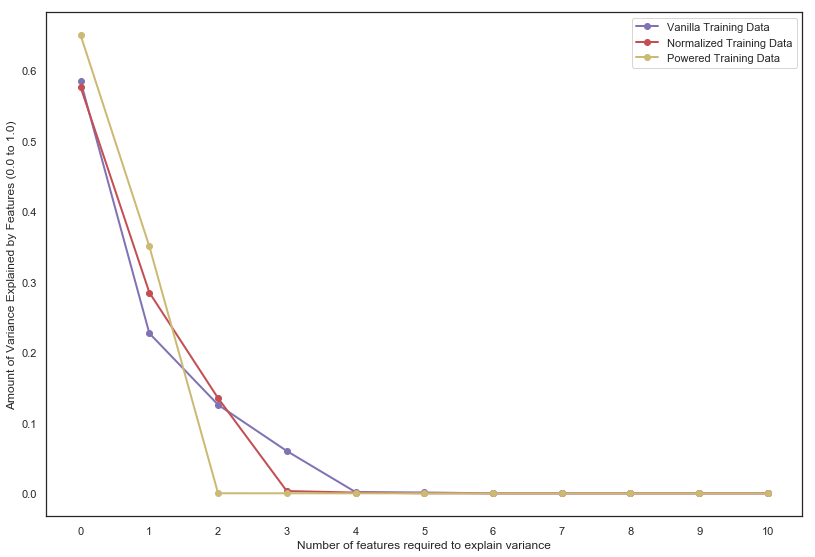

In [305]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Generate a new plot
plt.figure(1, figsize=(15, 10))
plt.clf()
plt.axes([.2, .2, .7, .7])

plt.plot(pca_v.explained_variance_ratio_, 'm-o', linewidth = 2, label = "Vanilla Training Data")
plt.plot(pca_n.explained_variance_ratio_, 'r-o', linewidth = 2, label = "Normalized Training Data")
#plt.plot(pca_r.explained_variance_ratio_, 'b-o', linewidth = 2, label = "Robusted Training Data")
plt.plot(pca_p.explained_variance_ratio_, 'y-o', linewidth = 2, label = "Powered Training Data")
#plt.plot(pca_s.explained_variance_ratio_, 'k-o', linewidth = 2, label = "Standardized Training Data")

## Set plot labels
plt.xlabel('Number of features required to explain variance')
plt.ylabel('Amount of Variance Explained by Features (0.0 to 1.0)')
plt.legend()

## Explicitly set the x-axis data so we can see where the drop-off is
plt.xticks(np.arange(0, 11, step=1))

## Show the graph!
plt.show()

## We hid the results of a few of the PCA analyses from the plot because they didn't provide much additional information, and made the plot look cluttered.

## The "vanilla" or untouched training data gave us the best sense of how much variance was being captured with more features.

## The "elbow" for this line is right on 4 features*.
* It says "3" on the y-axis of the plot because of Python's internal numbering scheme of starting on 0.

## If you observe the other lines, right when they hit 5*.  What does this tell us?  That after five features we're not getting much information gain.  This is something that we can assess later on.
*  6 features (thanks Python numbering!)

## Our next step to actually assess what those features might; it is not enough to know that we only <i>need</i> four or five features, we want to know which ones we should select.

## Right here we set up a variable to play to "snap" in different training instances for the plot below.

In [303]:
## SET A VARIABLE TO SWAP IN AND OUT BETWEEN THE DIFFERENT TRAINING INSTANCES

## Z = X_train_reg_encoded - Vanilla
## Z = X_train_reg_norm - Normalized
## Z = X_train_reg_robust - RobustScaled
## Z = X_train_power - PowerTransformed
Z = X_train_reg_standard ## - Standarized

## Start with identifying the best features using a `RandomForestRegressor`, this is a very widely used and useful technique for determing variance and information from features.

Feature ranking:
1. feature 3 (0.378317)
2. feature 1 (0.211950)
3. feature 6 (0.156055)
4. feature 7 (0.150919)
5. feature 4 (0.052406)


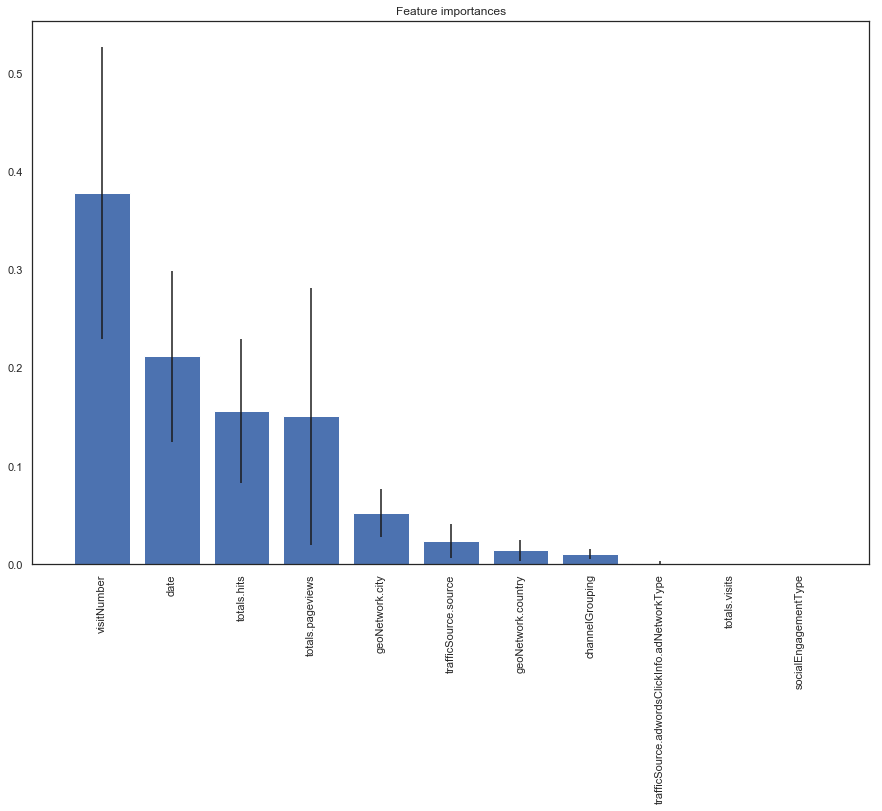

In [304]:
## Create a new classifier
clf_rf_5 = ensemble.RandomForestRegressor()      
clr_rf_5 = clf_rf_5.fit(Z, y_train_reg)

## Save our importances to a variable
importances = clr_rf_5.feature_importances_

## Get the standard deviation for each feature
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

## Print the feature ranking
print("Feature ranking:")

## Print the top five features, and their importance based on the Random Forest Classifier
for f in range(0, 5):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


## Plot the feature importances of the Random Forest Regressor - to see this visually

## Set the plot size
plt.figure(1, figsize=(15, 10))

## Set the title
plt.title("Feature importances")

## Plot a graph using all of the normalized features
plt.bar(range(Z.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")

plt.xticks(range(Z.shape[1]), feature_cols[indices], rotation=90)
plt.xlim([-1, Z.shape[1]])

## Show the graph!
plt.show()

## One of the best plots in the analysis - it provides so much information in a very intuitive way.

## What this tells us, according to the `RandomForestRegressor` mining process, is that the first eight features cover just about most of the variance for the data, and also provides us the label names for these features.

## We remove the channelGrouping feature from the analysis as well, as it contained a lot of empty or null fields.  That leaves us with lucky number 7.

## Here are the features that we've identified as the most important for our model:

1. visitNumber
2. date
3. total.hits
4. totalspageviews
5. geoNetwork.cty 
6. geoNetwork.state
7. traffic source

# <span style="color:#ffcc33">C.  Model Development, Assessment, and Testing</span>

## Now that we've identified our best features, we're ready to move on to the algorithm selection for the regression.

1.  We will re-initialize our training and testing data so we can start with a fresh set of data
2.  We now subset our data(frame) even further by using the seven features we selected above.
3.  We start with one algorithm, `GradientBoostedRegressor`, which is one of the better "out-of-the-box" algorithms avaiable in sklearn.

In [23]:
## Set a new variable with the columns we identified in our feature analysis
final_feature_cols = ["visitNumber", "date", "totals.hits", "totals.pageviews", 
                      "geoNetwork.city", "geoNetwork.country", "trafficSource.source"]

In [26]:
## Since we're running a regression, we don't need any of the rows that have 0 in spend - this just adds noise to the model
## We can just subset the data and remove these rows
spending_only = training_data_clean["Revenue"] != 0

## Create a separate instead of the dataframe that only contains training exmamples with spend
spending_only_df = training_data_clean[spending_only]

In [27]:
## Create our "X" variable that contains all the features we would like to use for our model(s)
X = np.array(spending_only_df[final_feature_cols])

## Create our second "y" variable - for our regression problem
y_regression = np.array(spending_only_df["Revenue"])

In [28]:
## Split data training 80 % and testing 20%
## We won't stratify the data for this part of the analysis - since we're performing a regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size = 0.2, random_state = 42)

In [32]:
## Encode the categorical data
fit_oe = oe.fit(X_train_reg)
X_train_reg_encoded = fit_oe.transform(X_train_reg)

In [33]:
## Show the encoded training data
X_train_reg_encoded

array([[  0., 118.,  32., ...,  27.,  62.,  23.],
       [  0., 355.,  20., ..., 121.,  62.,   0.],
       [  0., 186.,  38., ...,  96.,  62.,   0.],
       ...,
       [  3.,  43.,  14., ..., 121.,  62.,   7.],
       [  2., 210.,  20., ...,  58.,  62.,  23.],
       [  3., 217.,  20., ...,  95.,  62.,  23.]])

In [34]:
## Import the model selection components we will need for performing a Nested Cross Validation
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold

In [338]:
## Set up a cross validation grid for GBoost
### Use least squares loss for our regression
gbr_p_grid = {'loss': ['ls'], 
                 'n_estimators': [100, 200, 300, 400, 500], 
                 'max_depth': [3, 4, 5],
                 'min_samples_split': [2, 4, 6], 
                 'learning_rate': [0.01]}

In [334]:
## Set a number of trials to run for the models
num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_gbr = np.zeros(num_trials)

## Initiate a new Gradient Boost instance - to use in the nested cross validation step
gbr = ensemble.GradientBoostingRegressor()

In [ ]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Gradient Boosting Regression
    
    gbreg= GridSearchCV(estimator=gbr, param_grid=gbr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    gbreg.fit(X_train_reg_encoded, y_train_reg)
    
    nested_score = cross_val_score(gbreg, X = X_train_reg_encoded, y = y_train_reg, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_gbr[i] = nested_score.mean()

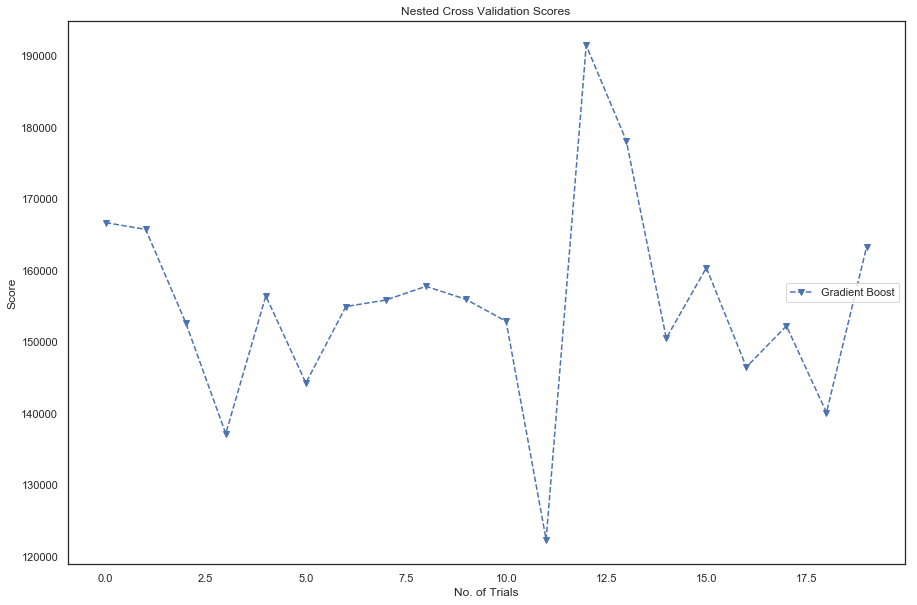

In [346]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_gbr*-1, 'v--', label = "Gradient Boost")

## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Score")

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## The output of the nested cross validation for GradientBoost shows us that we have a long way to go to identify a good model.

## The best that we were able to do after our first attempt with our first data mining algorithm was a MSE of 122344, which is an RMSE of ~349.  That is not a good score for one of the better algorithms.

## Below you will see some additional metrics being displayed of our first model.  We have to multiply the nested scores by -1 since the scoring function for `sklearn` is backwards.

In [351]:
## Get our best params
print(gbreg.best_params_)
print()

## Print out how well it performed using the best params
print(max(nested_scores_gbr)*-1)

{'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}

122344.24405501428


In [359]:
## Save our first set of results as a dataframe (really useful feature!)

gboost_regression_results_df = pd.DataFrame(gbreg.cv_results_)

In [361]:
## Show what the best model was for our first attempt

gboost_regression_results_df[gboost_regression_results_df["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
30,0.434278,0.002585,0.007501,0.000501,0.01,ls,5,2,100,"{'learning_rate': 0.01, 'loss': 'ls', 'max_dep...",...,-135985.513087,-159382.711206,63581.831147,1,-92558.056364,-84116.570548,-95780.325429,-80132.727874,-88146.920054,6288.839213


## After reviewing the results of the gradient boosted algorithm, we came to the realization that this data mining happened <i>without</i> normalization of the training data.

## Normalization is an important part of the model selection process; it is the process of scaling individual samples to have unit norm. This process can be useful if you plan to use a quadratic form such as the dot-product or any other kernel to quantify the similarity of any pair of samples.

## This could possibly be one of the reasons that the model did not perform well.  Before we try any other algorithms, we normalize the data first.

In [35]:
## We have a few different options here for standardizing the data set
## We can try one or two to see if they help with the model performance

X_train_reg_norm = preprocessing.Normalizer(norm = "l1").fit_transform(X_train_reg_encoded)
X_train_reg_robust = preprocessing.RobustScaler().fit_transform(X_train_reg_encoded)
X_train_reg_power = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(X_train_reg_encoded)
X_train_reg_standard = preprocessing.StandardScaler().fit_transform(X_train_reg_encoded)

In [36]:
print("Here is the output of 'normalized' training data: \n\n{}".format(X_train_reg_norm[0]))

print()

print("Here is the output of 'standardized' training data: \n\n{}".format(X_train_reg_standard[0]))

print()

print("Here is the output of 'robust' training data: \n\n{}".format(X_train_reg_robust[0]))

Here is the output of 'normalized' training data: 

[0.         0.40549828 0.10996564 0.09965636 0.09278351 0.21305842
 0.0790378 ]

Here is the output of 'standardized' training data: 

[-0.39815549 -0.59999724 -0.06630944  0.1656382  -1.79721072  0.18745187
  0.89148288]

Here is the output of 'robust' training data: 

[-0.33333333 -0.33695652  0.24        0.44444444 -1.30188679  0.
  1.        ]


## Another observation we made - we didn't perform any transformation of the target variable.  It is almost as important to normalize the target as it is the training data, especially if the data is sparse or there are many outliers, which is likely to be true in this scenario.

## To confirm our suspicions, we do a very quick look to see what the lowest and largest spend are - to see how large of a spread there is.

In [37]:
## Here's our spread of target variables, the revenue.

print(min(y_train_reg))

print()

print(max(y_train_reg))

0.09

23129.5


## Since there is a very large spread in the values, these outliers will really affect the data mining algorithms pretty significantly.

## We bring in our friend `RobustScaler`** to help us mitigate this problem.

** Scales features that are robust to outliers.  This scaler removes the median and scales the data according to the quantile range.  Typically, standardizatoin is done by removing the mean and scaling to unit variance, but outliers can often influence the sample mean and variance negatively.  In these cases, the median and interquartile range give better results. [6]

In [38]:
## Transform our training data using RobustScaler object
## We have to reshape the training data because it is a flat array, and the RobustScaler object is expecting a 2-D array
y_train_reg_robust = preprocessing.RobustScaler().fit_transform(y_train_reg.reshape(-1, 1))

## We then flatten the transformed target back to its original state
y_train_reg_robust = y_train_reg_robust.flatten()

## We show a few of the transformed targets to get a sense of the newly scaled data
y_train_reg_robust

array([-0.14856076, -0.36522944, -0.43773335, ...,  1.45856919,
       -0.30501024,  3.88275322])

## Now that we have a target variable set up on a better scale, and we have encoded our training data, we then continue our model discovery process.

## We set up the following algorithms:

1.  Decision Tree Regressor
2.  k-Nearest Neighbors Regressor
3.  Logistic Regression

## We also set up nested cross validation and grid search loops for each of the regression algorithms.

In [71]:
## Initiate a new instance of Decision Tree Regressor
dtr = tree.DecisionTreeRegressor()

## Set up a grid for the DecisionTree Regressor
dtr_p_grid = {"criterion": ["mse"],
            "splitter": ["best", "random"],
            "max_features": [4, 5, 6],
            "max_depth": [5, 10, 15]}

## Set a number of trials to run for the models
num_trials = 20

## Empty arrays to store scores for classifier
nested_scores_dtr = np.zeros(num_trials)

In [73]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for DecisionTree Regressor
    
    dtreg= GridSearchCV(estimator=dtr, param_grid=dtr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    dtreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(dtreg, X = X_train_reg_robust, y = y_train_reg_robust, 
                                   cv = outer_cv, scoring = "neg_mean_squared_error")
    
    nested_scores_dtr[i] = nested_score.mean()

In [79]:
## Set up a grid for kNN Regressor
## Going to use 1-30 neighbors, and two different distance calculations
knnr_p_grid = {"n_neighbors": list(range(1, 31)),
             "weights": ["uniform", "distance"]}

## Empty array to contain scores
nested_scores_knnr = np.zeros(num_trials)

## Initiate a new instance of k-Nearest Neighbors object
knnr = neighbors.KNeighborsRegressor()

In [80]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for kNN Regression
    
    knnreg= GridSearchCV(estimator=knnr, param_grid=knnr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    knnreg.fit(X_train_reg_robust, y_train_reg_robust)
    
    nested_score = cross_val_score(knnreg, X = X_train_reg_robust, y = y_train_reg_robust, cv = outer_cv, scoring = "neg_mean_squared_error")
    nested_scores_knnr[i] = nested_score.mean()

In [84]:
## Using L1 only, this is a SPARSE data set with outliers affecting the ability of the algorithms to perform the regression.
lr_p_grid = {"penalty": ["l1"],
            "C": [1, 5, 10, 50, 1000],
            "solver": ["liblinear"]}

## Empty array to contain scores
nested_scores_lr = np.zeros(num_trials)

## Linear Regression
lr = linear_model.LogisticRegression()

In [81]:
nested_scores_knnr*-1

array([24.0707382 , 21.95758347, 29.85873953, 20.5122735 , 22.42895763,
       24.91457173, 27.15988458, 22.18264625, 24.66857387, 27.30952729,
       23.7622061 , 27.12216166, 28.39615459, 23.08889251, 24.5915435 ,
       25.30453033, 27.42257336, 24.48367745, 22.27836749, 27.88740492])

In [88]:
y_train_reg_robust_int = y_train_reg_robust.astype(int)

In [ ]:
## Loop for each trial
for i in range(20):
    
    ## Choose cross-validation techniques for the inner and outer loops,
    ## independently of the dataset.
    inner_cv = KFold(n_splits = 4, shuffle = True, random_state = i)
    outer_cv = KFold(n_splits = 4, shuffle = True, random_state = i)

## Nested CV for Logit Regression
    
    lreg= GridSearchCV(estimator=lr, param_grid=lr_p_grid, cv=inner_cv, scoring = "neg_mean_squared_error")
    lreg.fit(X_train_reg_robust, y_train_reg_robust_int)
    
    nested_score = cross_val_score(lreg, X = X_train_reg_robust, y = y_train_reg_robust_int, cv = outer_cv,
                                  scoring = "neg_mean_squared_error")
    
    nested_scores_lr[i] = nested_score.mean()

## Each of the models were trained for 20 cycles, using a 4 fold approach.  We used `neg_mean_squared_error` as the scoring function since this is a regression problem.

## We had some challenges running the models concurrently on the VMs (and that is with running these models on Thanksgiving Day!).  Our Logistic Regression model was unable to complete because of an unfortunately timed reboot.

## We were able to save the scores after they had completed, which helped us plot them below.

In [42]:
## These were saved from some earlier attempt of learning and teaching the algorithms using the data we have.
## We recreated them to show the performance in the plot below

nested_scores_dtr = np.array([-31.39943409, -26.18296908, -33.74390274, -23.11733997,
                              -23.50775031, -27.17223886, -35.56159496, -27.83744961,
                              -24.64392742, -24.71263695, -28.82238863, -18.78039797,
                              -28.09451221, -25.1155978 , -21.31882621, -27.19112995,
                              -23.92971138, -29.72257172, -22.41733448, -23.04114399])

nested_scores_knnr = np.array([-24.0707382 , -21.95758347, -29.85873953, -20.5122735 ,
                               -22.42895763, -24.91457173, -27.15988458, -22.18264625,
                               -24.66857387, -27.30952729, -23.7622061 , -27.12216166,
                               -28.39615459, -23.08889251, -24.5915435 , -25.30453033,
                               -27.42257336, -24.48367745, -22.27836749, -27.88740492])

nested_scores_lr = np.array([-29.40859748, -35.62548849, -29.59769865, -39.6859531 ,
                             -30.18584455, -43.11278767, -29.33184976, -29.13547547,
                              0.        ,   0.        ,   0.        ,   0.        ,
                              0.        ,   0.        ,   0.        ,   0.        ,
                              0.        ,   0.        ,   0.        ,   0.        ])

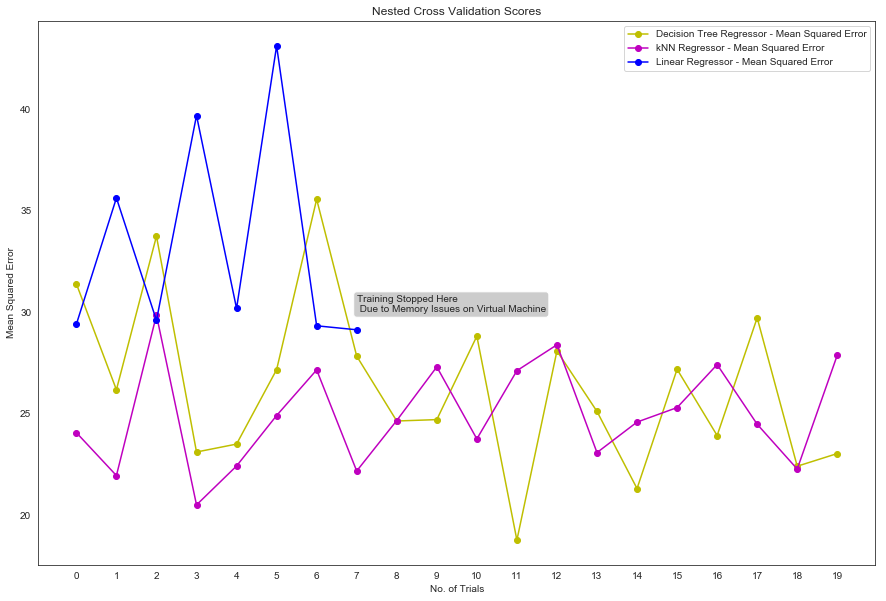

In [68]:
## Import the library that will make our regression problem a cinch!
import lightgbm as lgb

## Plot nested scores for each classifier - quickly visual the best performing model
## This is WITHOUT having changed any of the default parameters
plt.plot(nested_scores_dtr*-1, 'y-o', label = "Decision Tree Regressor - Mean Squared Error")
plt.plot(nested_scores_knnr*-1, 'm-o', label = "kNN Regressor - Mean Squared Error")
plt.plot(nested_scores_lr[:8]*-1, 'b-o', label = "Linear Regressor - Mean Squared Error")

bbox = dict(boxstyle = "round", fc = "0.8")

plt.annotate("Training Stopped Here\n Due to Memory Issues on Virtual Machine",
            (8, 29), xytext = (7, 30), bbox = bbox)

## Give some labels
plt.xlabel("No. of Trials")
plt.ylabel("Mean Squared Error")
plt.xticks(np.arange(0, 20, step = 1))

## Title and legend
plt.title("Nested Cross Validation Scores")
plt.legend()

## Show the graph
plt.show()

## We used the Mean Squared Error as the `objective function` & `error measurement`.

* An objective function is also known as a <b>loss function</b> (or optimization score function) and is one of the two parameters required to compile a model.

* The error measurement is also known as a <b>metric function</b>; it is used to assess how well the models are performing.  Metric functions are supplied in the metrics parameter when a model is compiled.

## We noticed that each model performed about the same, and the best MSE score was ~18 (which is an RMSE of 4.24) by our DecisionTreeRegressor.

## At this point in the regression analysis, it was clear that this was going to be more of an exploratory analytics type effort than earlier conceived.  We had attempted some of "out-of-the-box" algorithms and, up until this pont, had been unsuccessful in building a robust model.

## We decided to bring out the big guns and try some of the newer data mining techniques we had been exposed to.

## Our next step was to try building a Neural Network, using a similar technique we had used in a previous homework assignment.

1.  Build a two-layer neural network (using a function).
2.  Initialize a list of hidden units to test with the two layer model.
3.  Run some training epochs to see if the neural network could perform better than our earlier attempts.

In [69]:
## Import our libraries needed to build the Neural Network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [74]:
## Confirm the shape of the input and output data for the Neural Network
print("The shape of our input data is {}.".format(X_train_reg_robust.shape))

print()

print("The shape of our output is {}.".format(y_train_reg_robust.shape))

The shape of our input data is (9212, 7).

The shape of our output is (9212,).


In [75]:
## Cycle through these different hidden units for our two layer NN model
nb_hiddens = np.array([24, 48, 128, 256])

## Create a function to build the two layer model
def test_model_two(activation='relu', nb_hidden = 120):
    
    two_layer_model = Sequential()
    
    ## The first hidden layer will cycle through different hidden layers
    ## The model expects rows of data with 7 features (the 'input_dim = 7' argument)
    two_layer_model.add(Dense(nb_hidden, input_dim = 7, activation = "relu"))
    
    ## The second hidden layer will have the same number of hidden units as the first layer and uses the relu activation function.
    two_layer_model.add(Dense(nb_hidden, activation = "relu"))
    
    ## The output layer has one node and uses the linear activation function.
    two_layer_model.add(Dense(1, activation = "linear"))
    
    ## We will define the optimizer as the efficient stochastic gradient descent algorithm "adam". 
    ## This is a popular version of gradient descent because it automatically tunes itself and gives good results in a wide range of problems.
    two_layer_model.compile(loss = "mse", optimizer = "adam", metrics = ["mse"])
    
    ## Return the completed model
    return two_layer_model

In [79]:
## Save our results to an empty list so that we can capture this and plot it later
two_layer_model_results = []

## Loop through all of the hidden layers and replace the hidden units in each iteration of tests
for i in nb_hiddens:
    
    ## Establish a new version of our model above
    two_layer_model = test_model_two(nb_hidden = i)
    
    ## Save the history of the model and use 15% of the training data to validate our model results
    history = two_layer_model.fit(X_train_reg_robust, y_train_reg_robust, epochs = 20, verbose = 0, validation_split = 0.15)
    
    ## Save the results into the list above
    two_layer_model_results.append(history)

In [80]:
## Save our results to a new set of variables - so that we don't lose the history or the output from the first model run
first_run_loss_b = two_layer_model_results[0].history['loss']
second_run_loss_b = two_layer_model_results[1].history['loss']
third_run_loss_b = two_layer_model_results[2].history['loss']
fourth_run_loss_b = two_layer_model_results[3].history['loss']

## Save the results of our validation MSE as well - whichever does the best from the three will get tested with the actual data
first_run_mse_b = two_layer_model_results[0].history['val_mse']
second_run_mse_b = two_layer_model_results[1].history['val_mse']
third_run_mse_b = two_layer_model_results[2].history['val_mse']
fourth_run_mse_b = two_layer_model_results[3].history['val_mse']

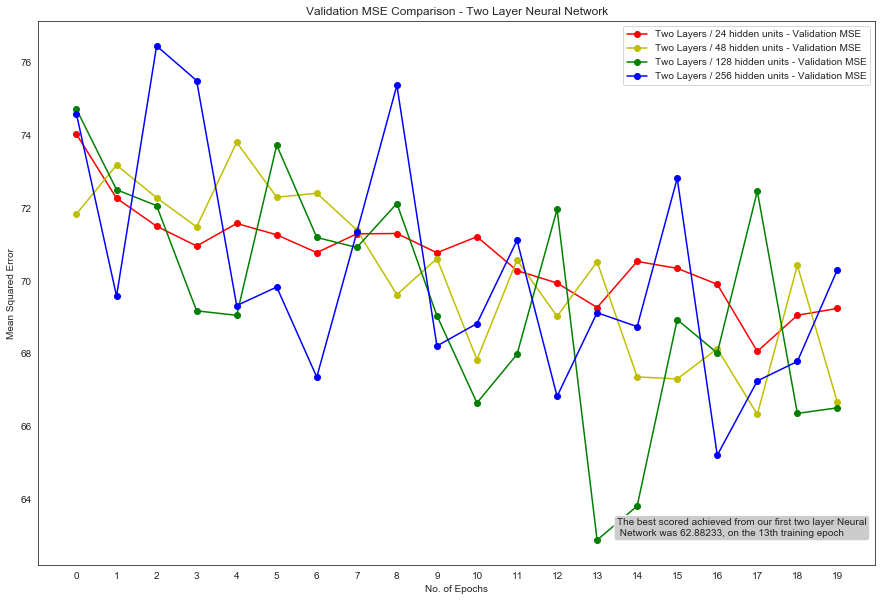

In [111]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each trial for nested CV

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot Mean Squared Error to quickly visual the best performing two layer model
plt.plot(first_run_mse_b, 'r-o', label = "Two Layers / 24 hidden units - Validation MSE")
plt.plot(second_run_mse_b, 'y-o', label = "Two Layers / 48 hidden units - Validation MSE")
plt.plot(third_run_mse_b, 'g-o', label = "Two Layers / 128 hidden units - Validation MSE")
plt.plot(fourth_run_mse_b, 'b-o', label = "Two Layers / 256 hidden units - Validation MSE")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Mean Squared Error")
plt.xticks(np.arange(0, 20, step = 1))

## Add an annotation explaining the best score
bbox = dict(boxstyle = "round", fc = "0.8")
plt.annotate("The best scored achieved from our first two layer Neural\n Network was 62.88233, on the 13th training epoch",
            (13.5, 63), bbox = bbox)

## Title and legend
plt.title("Validation MSE Comparison - Two Layer Neural Network")
plt.legend(loc = 'upper right')

## Show the graph
plt.show()

## And our hopes are dashed!  Our Neural Network model didn't perform as well as we had opened, and the best MSE we were able to obtain was 62 (which is an RMSE of 7.87).  This did not outperform our earlier attempts.

# <span style="color:#ffcc33">D. "Best" Model Identification & Parameter Tuning</span>

## Here is where we introduce our newest tool, `LightGBM` [3].

LightGBM is a gradient boosting framework using tree based learning algorithms.  It has the following "features" [5]:

* Faster training speed(YES PLEASE) and higher efficiency
* Lower memory usage
* Better accuracy (we love this!)
* Parallel and GPU learning
* Handling large-scale data

## As mentioned previously in the analysis, we realized that this had become an exploratory type analysis.

## Once we had discovered this new algorithm, we also reviewed the specifics of the competition one more time.

## This is where we made the realization that our "target" up until this point had been wrong.  The natural log of revenue was what were looking for, and not the revenue target column we had created on our own previously.

## Build an LGB Model :)

1.  Revisit our training data and create a new instance of training data
2.  Create a new target variable using the appropriate function - using a `np.log1p` function
3.  Use a pandas function `factorize` to transform our categorical features into integers [1]
4.  Convert all numeric fields to integer
5.  Run the model!

In [12]:
## Confirm that our original training data that was loaded is unscathed from all of our earlier exploratory work

training_data.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [13]:
## Fill transaction revenue column, our target, with zeros and convert to floating point measurement
target = training_data["totals.transactionRevenue"].fillna(0).astype(float)

## One of the most vital steps - transform the new target variable to 
target = target.apply(lambda x: np.log1p(x))

In [14]:
## We create a new instance of training data by assigning to a new variable
## This is just in case we ever need to run this specific part of the notebook, we don't overwrite any previously used variables

## Set a new variable with the columns we identified in our feature analysis
final_feature_cols = ["visitNumber", "date", "totals.hits", "totals.pageviews", 
                      "geoNetwork.city", "geoNetwork.country", "trafficSource.source"]

## Subset our new training data
new_train_data = training_data[final_feature_cols]

## Confirm the shape matches our original set of training data
print(new_train_data.shape)

(903653, 7)


In [15]:
## Set up a for loop to go through the columns in our new training data set
## If the data type is object - this means it is a categorical feature
## For the columns that contain categorical feature, we use factorize to transfrom them to numeric values
## This transformation happens "inplace" - we will overwrite the original columns with the newly factorized features

for col in new_train_data.columns:
    if new_train_data[col].dtypes == object:
        new_train_data[col], indexer = pd.factorize(new_train_data[col])

In [16]:
## One additonal step - fill the null/empty values for the "pageviews" column with zeros
## Then we transform this field into an integer field so that we have no floating point values left in our training data

new_train_data["totals.pageviews"] = new_train_data["totals.pageviews"].fillna(0).astype(int)

In [17]:
## Confirm that all of our datatypes are integer - this is needed for the LGB model

new_train_data.dtypes

visitNumber             int64
date                    int64
totals.hits             int64
totals.pageviews        int32
geoNetwork.city         int64
geoNetwork.country      int64
trafficSource.source    int64
dtype: object

## Now that we've done the initial set up for the LGB model, we're going to do a few extra steps

1.  Define our own RMSE metric by using wrapping a function around the `mean_squared_error` metric in sklearn
2.  Define a function for running the LGB model -  we will go through each hyperparameter in the function
3.  Run the function to train the model and review the output to see how it performs

Special thanks to a user on Kaggle for learning about the different parameters for LGB. [4]

In [102]:
## Import the library that will make our regression problem a cinch!
import lightgbm as lgb

## Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

## Define our own function for calculating the RMSE
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

In [40]:
## Create a function to build our LGB model
## We'll go into detail on each hyper as we build it

def lgb_model(X_train, y_train, X_val, y_val, X_test):
    
    ## Build a dictionary with our parameters
    ## We mimic-ed another sample notebook for some of these parameter settings
    params = {
        
        ## Learning objectives and rates
        "objective": "regression", ## Performing a regression problem
        "metric": "rmse", ## Use rmse, our custom function, as our metric to be used on our evaluation set
        "num_leaves": 40, ## max number of leaves in one tree
        "learning_rate": 0.005, ## also known as shrinkage rate, we go with a low value to give the algorithm better chance to learn
        
        ## Bagging to help with overfitting and to speed up our training
        "bagging_fraction": 0.6, ## Randomly select part of data without replacement to help with overfitting
        "bagging_frequency": 6, ## Perform bagging every 6th iteration
        "bagging_seed": 42, ## Random seed for bagging, 42 because it is the answer to everything
        
        ## Randomly select part of features on each iteration (tree)
        "feature_fraction": 0.6, ## Select 60% of features before training each tree
        
        ## Only warn if there is a "fatal" error
        "verbosity" : -1,
        ## Seed used to generate all other seeds, one seed to rule them all
        "seed": 42
    }
    
    ## First thing that is different about LGB, it takes a different object than our earlier algorithms
    ## LightGBM can load data from csv, txt, numpy arrays, pandas DataFrame - very flexible
    lgb_train_data = lgb.Dataset(X_train, label = y_train)
    lgb_val_data = lgb.Dataset(X_val, label = y_val)
    
    ## Build the actual LGB Model, now that we have set up our parameters, training, and validation data set up
    model = lgb.train(params, ## Parameters for training
                      lgb_train_data, ## Data to be trained on
                     num_boost_round = 5000, ## Number of boosting iterations
                     valid_sets = [lgb_train_data, lgb_val_data], ## List of data to be evaluated on during training
                     early_stopping_rounds = 200, ## Activates early stopping, where the model will training only until validation score stops improving
                     verbose_eval = 500) ## Evaluation metric will be printed on every 500th boosting stage, and the last boosting stage will print
    
    ## Use the model to predict Revenue on our training data
    y_pred_train = model.predict(X_train, num_iteration = model.best_iteration)
    
    ## Use the same model to predict Revenue on our validation data
    y_pred_val = model.predict(X_val, num_iteration = model.best_iteration)
    
    ## Commenting this line from the original function - we'll create a separate one for running against the testing data
##    y_pred_submit = model.predict(X_test, num_iteration = model.best_iteration)
    
    ## Print  out the results of our RMSE function using the training and validation
    print(f"LGBM: RMSE val: {rmse(y_val, y_pred_val)} - RMSE train: {rmse(y_train, y_pred_train)}")
    
    ## Return our predicted values for the validation data, and the final model
    return y_pred_val, model

In [18]:
## Create our "X" variable that contains all the features we would like to use for our model
X = new_train_data

## Create our second "y" variable - for our regression problem using our new target variable
y_regression = target

In [19]:
## Split data training 85 % and testing 15%
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X, y_regression, 
                                                                    test_size = 0.15, random_state = 42)

In [20]:
## Just confirming how much data we have to train and validate against
print("Train shape: {}".format(X_train_reg.shape))
print()
print("Validation shape: {}".format(X_val_reg.shape))

Train shape: (768105, 7)

Validation shape: (135548, 7)


## We're ready to try our newly created model!  We run it twice, to also capture how quickly it is able to perform training and validation concurrently.

## One of the benefits of LGBM is speed - so let's see how it does!

In [46]:
%%time

## Train LGBM and generate predictions - get the output
lgb_preds, lgb_model_output = lgb_model(X_train_reg, y_train_reg, 
                               X_val_reg, y_val_reg, X_test_reg)

Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 1.65597	valid_1's rmse: 1.66146
[1000]	training's rmse: 1.61644	valid_1's rmse: 1.63829
[1500]	training's rmse: 1.59667	valid_1's rmse: 1.63148
[2000]	training's rmse: 1.58229	valid_1's rmse: 1.62939
[2500]	training's rmse: 1.57079	valid_1's rmse: 1.62905
[3000]	training's rmse: 1.56038	valid_1's rmse: 1.62844
Early stopping, best iteration is:
[3276]	training's rmse: 1.5551	valid_1's rmse: 1.62817
LGBM: RMSE val: 1.62817 - RMSE train: 1.5551
Wall time: 1min 21s


## 1min 21s to train!  That's really fast compared to some of our other algorithms.  We'll be showing a comparison of our results in a separate file.

In [47]:
## Train LGBM and generate predictions - get the output
lgb_preds, lgb_model_output = lgb_model(X_train_reg, y_train_reg, 
                               X_val_reg, y_val_reg, X_test_reg)

Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 1.65597	valid_1's rmse: 1.66146
[1000]	training's rmse: 1.61644	valid_1's rmse: 1.63829
[1500]	training's rmse: 1.59667	valid_1's rmse: 1.63148
[2000]	training's rmse: 1.58229	valid_1's rmse: 1.62939
[2500]	training's rmse: 1.57079	valid_1's rmse: 1.62905
[3000]	training's rmse: 1.56038	valid_1's rmse: 1.62844
Early stopping, best iteration is:
[3276]	training's rmse: 1.5551	valid_1's rmse: 1.62817
LGBM: RMSE val: 1.62817 - RMSE train: 1.5551


## Our best RMSE by almost 3 - the LGB algorithm is working much better than we had expected.  Let's see how it ranked the feature importance, for the seven features we selected.

In [56]:
print("LightGBM feature importance:")
print()

## Obtain the model's 
gain = lgb_model_output.feature_importance("gain")

## Create a dataframe with the feature - using the feature name
feature_importance = pd.DataFrame({"feature": lgb_model_output.feature_name(),
                                   
                          ## How many of the features were used to learn
                          "split": lgb_model_output.feature_importance("split"),
                                   
                          ## Calculate the percent gain for each one of our features and sort them in order of high importance to low importance
                          "gain": 100 * gain / gain.sum()}).sort_values("gain",
                                                                       ascending = False)
## Display the dataframe!
print(feature_importance)

LightGBM feature importance:

                feature  split       gain
3      totals.pageviews  22937  39.359488
2           totals.hits  24231  20.268550
5    geoNetwork.country   8059  11.490184
0           visitNumber  17199   9.355165
6  trafficSource.source  11723   7.663288
1                  date  25161   6.763533
4       geoNetwork.city  18454   5.099792


## This is by far the best performance that we have seen out of the various models that we tried to use.

## After such an exhaustive search, we're finally confident enough of a model to use it on our testing data.

In [58]:
## Save our model in case we would like to load it on a different machine
## Or to save time for later analysis

lgb_model_output.save_model("LGBModel_Google_Analytics_Customer_Revenue_Regression.txt")

## Now that we've saved the model, we can save a little bit of time by just loading it from the text file.  This saves us from having to re-train.

## LGB Also has some very nice plots that come with the library built in.  We demo a few here just to demonstrate the model's selection criteria.

In [24]:
## Import the library that will make our regression problem a cinch!
import lightgbm as lgb

In [25]:
## Set a variable for the file name

lgb_model_file = "LGBModel_Google_Analytics_Customer_Revenue_Regression.txt"

lgb_model_path = working_dir+lgb_model_file

## Confirm the path of the file is correct
lgb_model_path

'D:\\Group 1\\datasets\\LGBModel_Google_Analytics_Customer_Revenue_Regression.txt'

In [26]:
## Pull in our completed model

lgb_model_output = lgb.Booster(model_file = lgb_model_path)

## Here we demo a few different plots that come packaged with `LightGBM`:

Plotting feature importances...


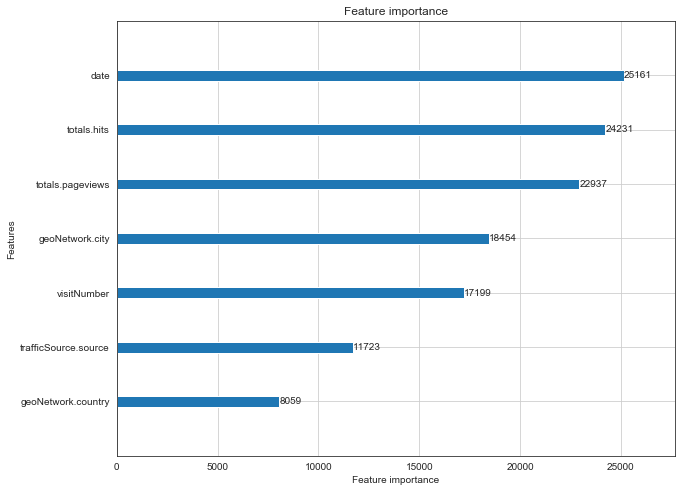

In [51]:
## Plot the feature importance - based on our seven features

print("Plotting feature importances...")

feature_plot = lgb.plot_importance(lgb_model_output, figsize = (10, 8))

plt.show()

Plotting split value histogram for visitNumber...


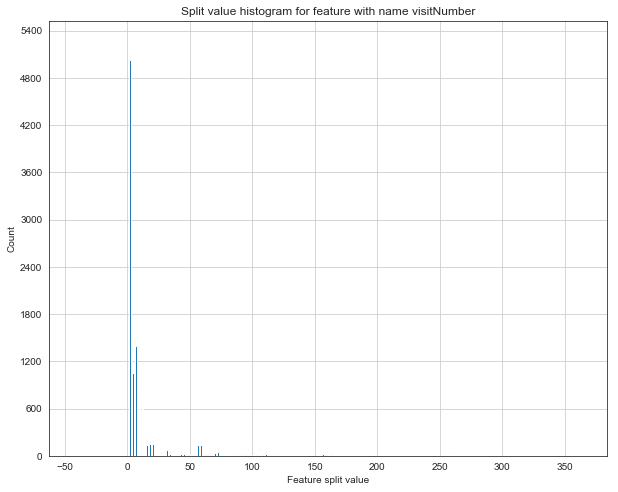

In [52]:
## Plot the feature importance - based on our seven features

print("Plotting split value histogram for visitNumber...")

lgb.plot_split_value_histogram(lgb_model_output, "visitNumber", bins = "auto", figsize = (10, 8))

plt.show()

In [39]:
## To build the last graph, we have to import graphviz, a special library
## We had to download the graphviz bin file to get these to render

import os
os.environ["PATH"] += os.pathsep + 'D:\\Group 1\\release\\bin'

## One of the best built in graphics in the library - it plots out a selected "tree" and shows the decision making process of the algorithm.

## This ties all the way back IDSC 6450 and logic gates*.  What an interesting visualization!

- Logic gate*: An idealized or physical device implementing a Boolean function; that is, it performs a logical operation on one or more binary inputs and produces a single binary output

Plotting 1st tree with graphviz...


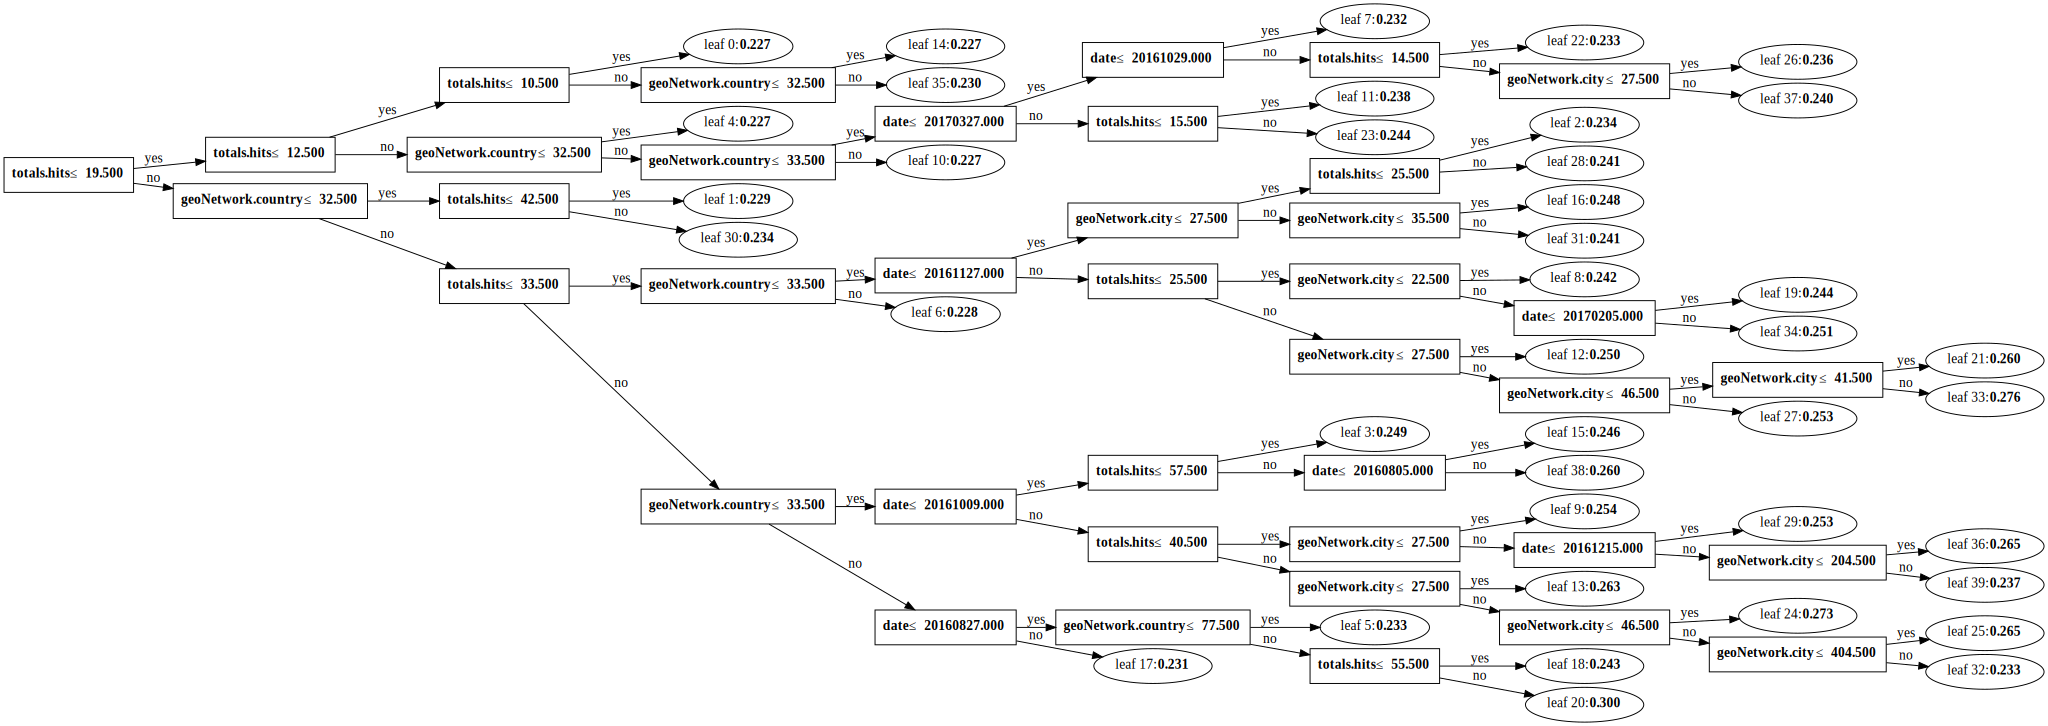

In [55]:
print('Plotting 1st tree with graphviz...')

lgb.create_tree_digraph(lgb_model_output, tree_index = 0, name = "Tree 0")

Plotting 50th tree with graphviz...


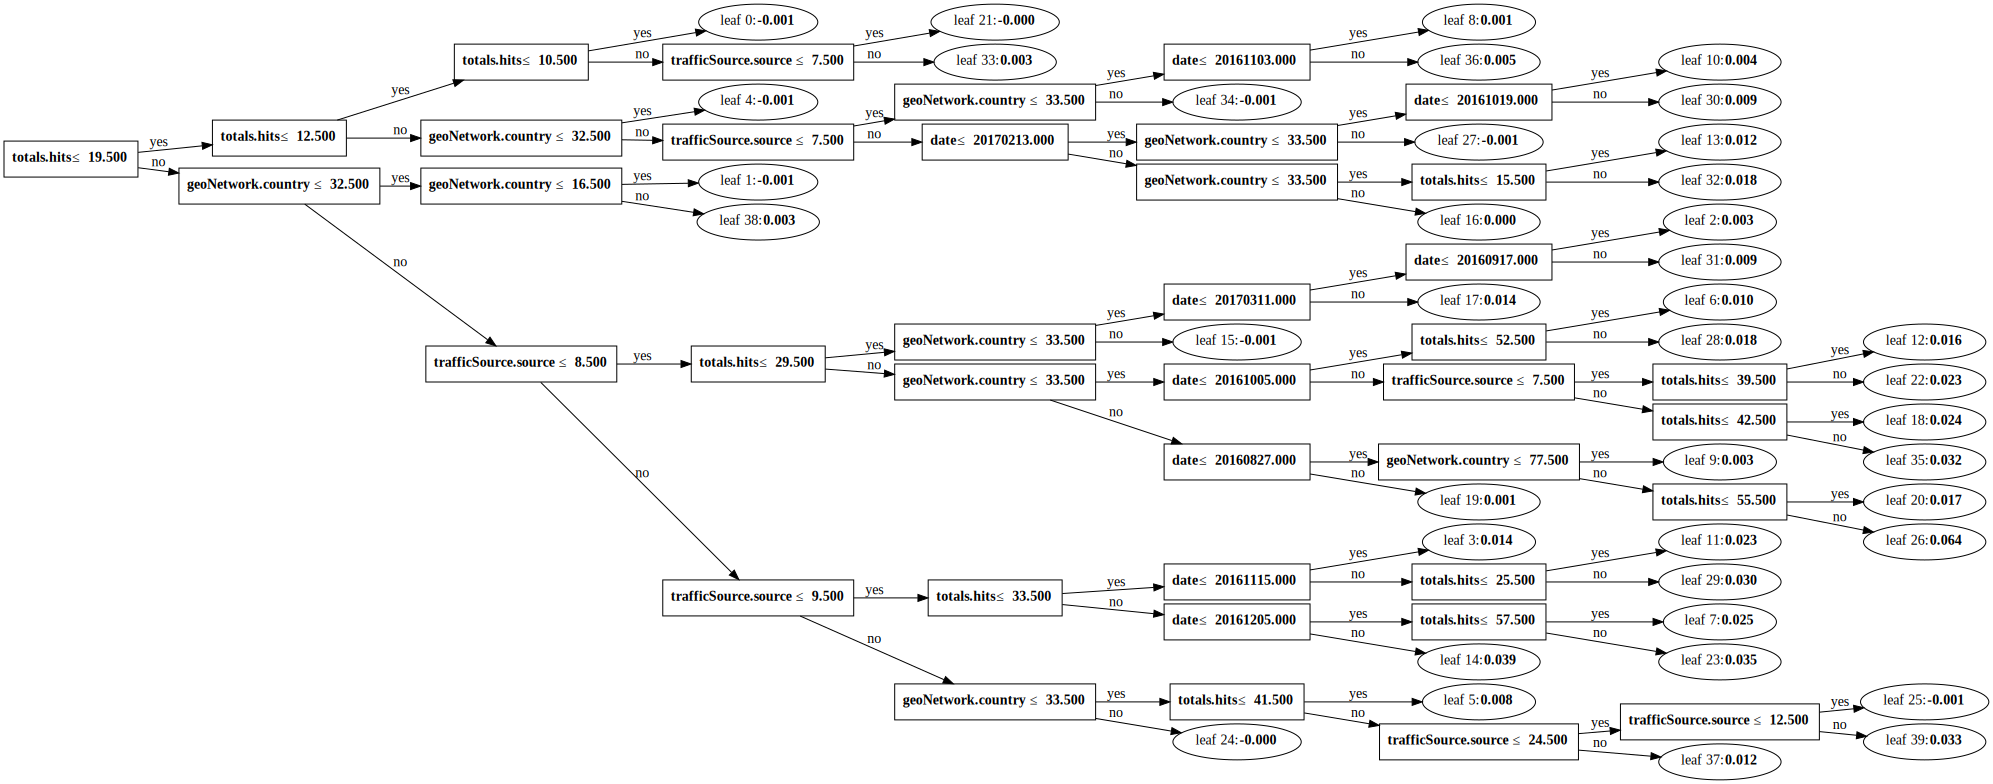

In [56]:
print('Plotting 50th tree with graphviz...')

lgb.create_tree_digraph(lgb_model_output, tree_index = 50, name = "Tree 50")

# <span style="color:#ffcc33">E. Final Model Training, Predictions, and Submission Output</span>

## We're finally here!  We have arrived at a model that we believe will perform well at its regression task for this data set.

1.  We <i>finally</i> load in our testing data, using a new batch
2.  Run the testing data through similar pre-processing steps as noted above
3.  Run our predictions and gather metrics on the output
4.  Assess the validity of the model

In [60]:
## Load in the training data from the flattened CSV file
## We're finally ready to fully evaluate our algorithm with testing data
testing_data = pd.read_csv(testing_v2_path, low_memory = False)

In [62]:
## Confirm structure of the data is same as the training data
testing_data.shape

(401589, 59)

In [63]:
## New testing data, subsetted to the same cols as our training
new_test_data = testing_data[final_feature_cols]

In [64]:
## Run some basic summary statistics on subsetted testing data
## I'll run this same thing again after we do some manipulation to transform categorical columns to numeric

new_test_data.describe()

,visitNumber,date,totals.hits,totals.pageviews
count,401589.000000,4.015890e+05,401589.000000,401488.000000
mean,2.486104,2.018073e+07,5.226087,4.214542
std,10.699105,1.628911e+02,9.313409,6.505109
min,1.000000,2.018050e+07,1.000000,1.000000
25%,1.000000,2.018060e+07,1.000000,1.000000
50%,1.000000,2.018072e+07,2.000000,2.000000
75%,2.000000,2.018090e+07,6.000000,5.000000
max,523.000000,2.018102e+07,500.000000,500.000000


In [65]:
## In a later tuning effort, we could place all of this into a function to save time
## But as we were exploring and building at the same time, we can just run it in the notebook
## Same transformation as was performed on training data above
for col in new_test_data.columns:
    if new_test_data[col].dtypes == object:
        new_test_data[col], indexer = pd.factorize(new_test_data[col])
        
## Same as above
new_test_data["totals.pageviews"] = new_test_data["totals.pageviews"].fillna(0).astype(int)

In [66]:
## Confirm the data types match

print(new_train_data.dtypes)
print()
print(new_test_data.dtypes)

visitNumber             int64
date                    int64
totals.hits             int64
totals.pageviews        int32
geoNetwork.city         int64
geoNetwork.country      int64
trafficSource.source    int64
dtype: object

visitNumber             int64
date                    int64
totals.hits             int64
totals.pageviews        int32
geoNetwork.city         int64
geoNetwork.country      int64
trafficSource.source    int64
dtype: object


## Now we're ready to rock - we have our testing data in the same format as our training data - let's see how it goes!

In [67]:
## We can finally create our testing data set!  It is ready

X_test_reg = new_test_data

## Confirm the shape our testing data
print("Testing shape: {}".format(X_test_reg.shape))

Testing shape: (401589, 7)


In [70]:
## Mimicing something we did earlier, we can just run our predictions on the testing data
## And see how it performs
y_pred_submit = lgb_model_output.predict(X_test_reg, num_iteration = lgb_model_output.best_iteration)

## Here we create a submission file for the (expired) competition.  We had a nightmare time trying to figure out the discrepancy between the output here and the trying to get it uploaded to Kaggle - so we leave the function here as sample output.

In [45]:
## Generate the submission file using the model we just finished training

def create_submission_file(preds):
      
    submission = testing_data[["fullVisitorId"]].copy()
    
    submission.loc[:, "PredictedLogRevenue"] = preds
    
    grouped_test = submission[["fullVisitorId", "PredictedLogRevenue"]].groupby("fullVisitorId").sum().reset_index()
    
    return grouped_test.to_csv(filename, index = False)

## We also performed some metrics testing of the models in a separate notebook.  That's where we compare the models to one another for timing and MSE/RMSE scores.  These tests were extensively long and required a lot of time on the VMs, and that is why they are not included here.

## Sited Works

<b>[1]</b>  (2019, February 21).  Google Analytics Customer Revenue Prediction.  <i>Kaggle</i>.  Retrieved from https://www.kaggle.com/c/ga-customer-revenue-prediction

<b>[2]</b>  Peller, J.  (2018, September 25).  Quick start: read csv and flatten json fields.  <i>Kaggle</i>.  Retrieved from https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
    
<b>[3]</b>  (2019, November 28).  LightGBM, Light Gradient Boosting Machine.  <i>GitHub</i>.  Retreived from https://github.com/microsoft/LightGBM
    
<b>[4]</b>  FabienDaniel.  (2018, September 25).  LGBM (RF) starter.  <i>Kaggle</i>.  Retrieved from https://www.kaggle.com/fabiendaniel/lgbm-starter
    
<b>[5]</b> Swalin, Alvira.  (2018, March 13).  CatBoost vs. Light GBM vs. XGBoost.  <i>Towards Data Science</i>.  Retrieved from https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

<b>[6]</b>  (2019, November 28).  RobustScaler.  <i>sklearn</i>.  Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler